# MRI Brain Defacing with a AI skullstrip model

#### This is a mini 'how-to' for my defacing project.

#### It covers the broad strokes but glosses over complexities.

## Please note that I have not included any data.  You will need to provide your own 3D <u>T1</u> MRI data.

This is easily acquired from online repositories such as OASIS, ADNI, SIMON and TCIA.  You will likely need to agree to their terms and conditions.

I have modified this code to load NIFTI data (.nii or .nii.gz files) to make it easier to work with their data.

In [1]:
import matplotlib.pyplot as plt  # for image display
import deepbrain2 as deepbrain   # brain segmentation
import numpy as np               # powerful numerical operations
import nibabel as nib            # for handling NIFTI files


## Define which NIFTI file you want to open.

This is your T1 volume - ideally a 3D aquisition.  <u>It needs to be T1 as DeepBrain will fail to properly segment other MRI sequences.</u>

**_Caveat:_** NIFTI files are not always stored in the same orientation, so what might be described as a 'sagittal' image in this notebook might appear as a coronal or axial depending on the NIFTI file you supply.

In [2]:
from pathlib import Path

src_image_path = Path(r'sample_T1_volume.nii.gz')

### Functions of convenience - tools to plot nice before and after images and explore the volume data.

In [3]:
def plot_3_axis(vol):
    # shows mid-saggital, mid-coronal and mid-axial slices
    i, j, k = np.shape(vol)

    plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(vol[:,:,(k//2)], cmap=plt.cm.Greys_r)

    plt.subplot(1,3,2)
    plt.imshow(vol[:,(j//2),:], cmap=plt.cm.Greys_r)

    plt.subplot(1,3,3)
    plt.imshow(vol[(i//2),:,:], cmap=plt.cm.Greys_r)

    plt.show()


def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

def minmax( dataset ):
    min = np.amin( dataset )
    max = np.amax( dataset )
    shape = np.shape( dataset )
    vartype = dataset.dtype
    print(f'Shape: {shape}  \tmin: {min}  \tmax: {max}  \ttype: {vartype}')

#### NIFTI volume re-orientation to match our expectations

This is not foolproof.

In [4]:
def check_orientation(ct_image, ct_arr):
    """
    Check the NIFTI orientation, and flip to 'RPS' if needed.
    :param ct_image: NIFTI file
    :param ct_arr: array file
    :return: array after flipping
    https://stackoverflow.com/questions/66231763/how-to-check-nifti-image-is-in-the-right-orientation-position-with-python
    """
    x, y, z = nib.aff2axcodes(ct_image.affine)
    print(f'Affine codes: x:{x} y:{y} z:{z}')
    if x != 'R':
        ct_arr = nib.orientations.flip_axis(ct_arr, axis=0)
    if y != 'A':
        ct_arr = nib.orientations.flip_axis(ct_arr, axis=1)
    if z != 'S':
        ct_arr = nib.orientations.flip_axis(ct_arr, axis=2)
    return ct_arr

### Load the 3D volume from the NIFTI file

We load the data from a NIFTI file - this is easier when using data from the online sources which are almost always in NIFTI format.

In [5]:
nii_file = nib.load(src_image_path)
volume = nii_file.get_fdata()

volume = check_orientation(nii_file, volume)

# volume = loadDcmVolume(src_image_path)

Affine codes: x:R y:A z:S


We should have a look to see what sort of data we have loaded

In [6]:
minmax(volume)

Shape: (176, 240, 256)  	min: 0.0  	max: 1203.0  	type: float64


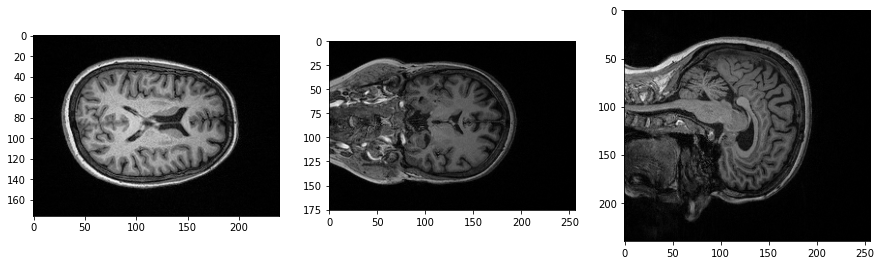

In [7]:
# shows mid-saggital, mid-coronal and mid-axial slices
i, j, k = np.shape(volume)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(volume[:,:,k//2], cmap=plt.cm.Greys_r)

plt.subplot(1,3,2)
plt.imshow(volume[:,j//2,:], cmap=plt.cm.Greys_r)

plt.subplot(1,3,3)
plt.imshow(volume[i//2,:,:], cmap=plt.cm.Greys_r)

plt.show()

## We defined the `plot_3_axis()` function above so we can now abbreviate the above code cell to:

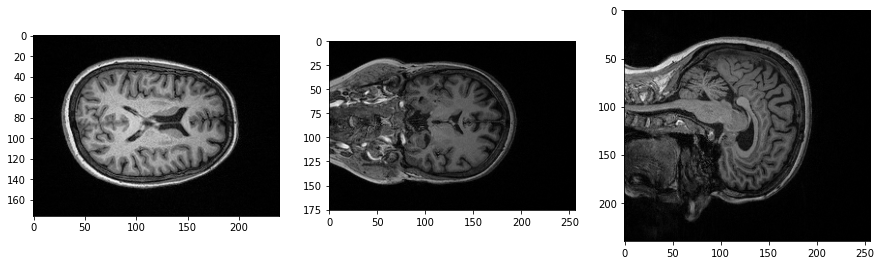

In [8]:
plot_3_axis(volume)

#### So this is a 3D volume - probably acquired in sagittal given the sag images are 256x256.

##### 171 slices

Individual voxel values range from 0 to 4000


## Deepbrain code.

This is made ridiculously easy by the author.  This version is modified to work with Tensorflow 2.

Original code here: https://github.com/iitzco/deepbrain 

In [9]:
ext = deepbrain.Extractor()

# `prob` will be a 3d numpy image containing probability 
# of being brain tissue for each of the voxels in `img`
prob = ext.run(volume) 

# a binary mask can be obtained by thresholding the probability volume:
mask = prob > 0.8

Instructions for updating:
Use tf.gfile.GFile.


## Sanity check of the T1 volume and mask data

In [10]:
print(f'Volume:\t',end='')
minmax( volume[:,:,128] )

print(f'Prob:\t',end='')
minmax( prob[:,:,128])
      
print(f'Mask:\t',end='')
minmax( mask[:,:,128])

slice_T1 = volume[128,:,:]
slice_prob = prob[128,:,:]
slice_mask = mask[128,:,:]

Volume:	Shape: (176, 240)  	min: 0.0  	max: 606.0  	type: float64
Prob:	Shape: (176, 240)  	min: 0.0  	max: 1.0  	type: float32
Mask:	Shape: (176, 240)  	min: False  	max: True  	type: bool


##### We can see a bit more of the AI model output.

We are interested in 'mask' which is a _binary_ _mask_.  This has interesting properties we will see later.

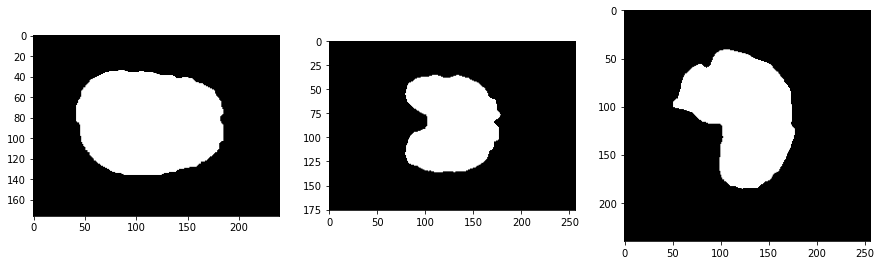

In [11]:
plot_3_axis(mask)

### This is where the mask gets powerful

In [12]:
masked_volume = volume * mask

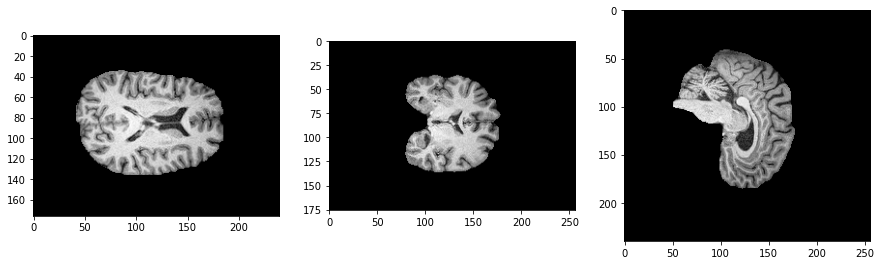

In [13]:
plot_3_axis(masked_volume)

### We can see that the only voxels remaining are those recognised as brain by the AI model - everything else has been masked out.

#### This is the power of the binary mask

##### This is really useful.  But, we just want to deface, not totally skullstrip.

##### Let's manipulate the mask a bit more before we apply it to the original T1 volume again.

Step 1 - try to fill in the gaps with a convex hull algorithm from SciKit Image

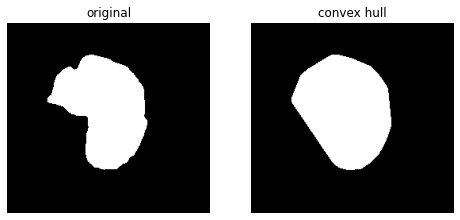

In [14]:
from skimage.morphology import convex_hull_image

sagSlice = mask[i//2,:,:]

hull1 = convex_hull_image(sagSlice == True)

plot_comparison(sagSlice, hull1, 'convex hull')

### Nice! let's do that for the whole volume

In [15]:
# remember the axes are i, j, k - there are i slices in the sagittal plane.
# This may vary inbetween NIFTI files

for img_number in range(i):
    mask[img_number,:,:] = convex_hull_image(sagSlice == True)

## Now grow the mask

In [16]:
from skimage.morphology import ball, binary_dilation

dilated_mask = np.copy(mask)

kernal = ball(1)
for iteration in range(15):
    dilated_mask = binary_dilation(dilated_mask, kernal)


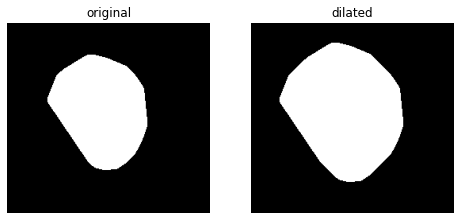

In [17]:
plot_comparison(mask[i//2,:,:], dilated_mask[i//2,:,:], 'dilated')

## Now the mask is bigger, maybe it is enough?

In [18]:
final_volume = volume * dilated_mask

Original Volume


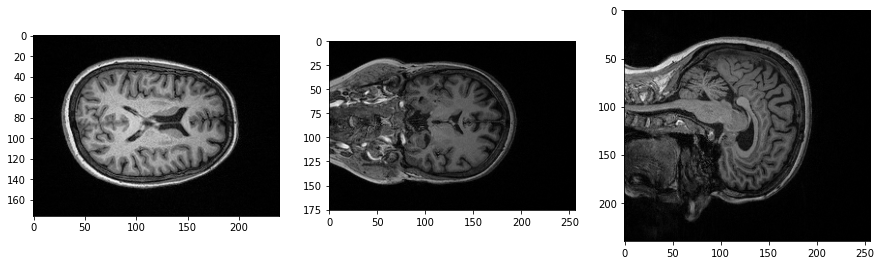

Defaced Volume


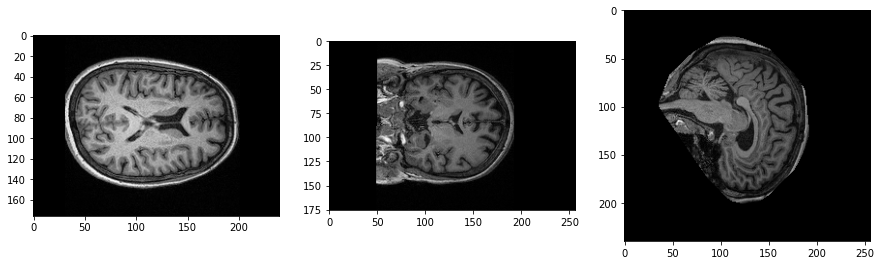

In [19]:
print('Original Volume')
plot_3_axis(volume)

print('Defaced Volume')
plot_3_axis(final_volume)


## Final Outcome - Not bad!

#### It can definitely use a bit of improvement - the neck soft tissues are removed and perhaps more tissue around the eyes could be removed.